## Bike Sharing in Boston
#### (Exploratory Data Analysis 2019 vs 2020)
##### Source = https://www.kaggle.com/jackdaoud/bluebikes-in-boston

#### First, we need to import neccessary libraries and loading the datasets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
trip_2019 = pd.read_csv("bluebikes_tripdata_2019.csv")
trip_2020 = pd.read_csv("bluebikes_tripdata_2020.csv")

C:\Users\ayhan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Let's take a look what we got

In [3]:
#trip_2019.head()
#trip_2019.tail()

#trip_2020.head()
#trip_2019.tail()

In [4]:
pd.DataFrame([trip_2019.dtypes,trip_2020.dtypes], index=[2019,2020])
# It seems we have postal code in 2020 and not in 2019, ok we will take care of this later

' It seems we have postal code in 2020 and not in 2019, ok we will take care of this later '

In [5]:
print("Value Counts(2019):",len(trip_2019))
print("Value Counts(2020):",len(trip_2020))
print("Ratio of 2020 usage compared to 2019:", round((len(trip_2020)-len(trip_2019))/len(trip_2019),2))

Value Counts(2019): 2522771
Value Counts(2020): 1999446
Ratio of 2020 usage compared to 2019: -0.21


' Bike sharing seems to have decreased 21% from 2019 to 2020 '

#### Dealing with Null Values (if exists)

In [6]:
## Checking 2019 data if there is any null value
outcome_2019 = []
for col in range(len(trip_2019.columns)):
    check = trip_2019[trip_2019.columns[col]]
    check_null = sum(check.isnull())
    outcome_2019.append(check_null)

null_count_2019 = pd.DataFrame(data=outcome_2019).T
null_count_2019.columns = trip_2019.columns
null_count_2019

# Ok we do not have any null values in 2019, that is great '''

' Ok we do not have any null values in 2019, that is great '

In [7]:
## Checking 2020 data if there is any null value
outcome_2020 = []
for col in range(len(trip_2020.columns)):
    check = trip_2020[trip_2020.columns[col]]
    check_null = sum(check.isnull())
    outcome_2020.append(check_null)

null_count_2020 = pd.DataFrame(data=outcome_2020).T
null_count_2020.columns = trip_2020.columns
null_count_2020

# We will deal with these null values

' We will deal with these null values '

In [8]:
## Calculate the null value ratio in 2020
gender_null_rate = sum(trip_2020["gender"].isnull()) / len(trip_2020["gender"])
birth_null_rate = sum(trip_2020["birth year"].isnull()) / len(trip_2020["birth year"])
postal_null_rate = sum(trip_2020["postal code"].isnull()) / len(trip_2020["postal code"])
[gender_null_rate, birth_null_rate, postal_null_rate]

[0.791954371360867, 0.791954371360867, 0.27873170868330527]

In [9]:
# Lets drop these columns because of the having major null-value-ratio
trip_2019.drop(["gender","birth year"], axis=1, inplace=True)
trip_2020.drop(["gender","birth year","postal code"], axis=1, inplace=True)

In [10]:
# trip_2019.head()
# trip_2020.head()

#### Dealing with Outliers

In [11]:
## Finding outliers with using Z score
outliers=[]
def detect_outlier(data_1):
    
    outliers.clear()
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [12]:
outlier_tripduration_2019 = len(detect_outlier(trip_2019["tripduration"])) / len(trip_2019["tripduration"])
outlier_tripduration_2020 = len(detect_outlier(trip_2020["tripduration"])) / len(trip_2020["tripduration"])
print("2019 Trip Duration Outlier Ratio:", round(outlier_tripduration_2019,4))
print("2020 Trip Duration Outlier Ratio:", round(outlier_tripduration_2020,4))

2019 Trip Duration Outlier Ratio: 0.0005
2020 Trip Duration Outlier Ratio: 0.0013


#### Correlations between trip duration and start/end station

In [13]:
print("Trip Duration & Start Station Corr (2019):" , round(trip_2019["tripduration"].corr(trip_2019["start station id"]),4))
print("Trip Duration & End Station Corr (2019):" , round(trip_2019["tripduration"].corr(trip_2019["end station id"]),4))

Trip Duration & Start Station Corr (2019): 0.0044
Trip Duration & End Station Corr (2019): -0.0022


In [14]:
print("Trip Duration & Start Station Corr (2020):" , round(trip_2020["tripduration"].corr(trip_2020["start station id"]),4))
print("Trip Duration & End Station Corr (2020):" , round(trip_2020["tripduration"].corr(trip_2020["end station id"]),4))

Trip Duration & Start Station Corr (2020): 0.0061
Trip Duration & End Station Corr (2020): -0.0006


#### Checking the change in bike id

' Probably bikes are getting renewed '

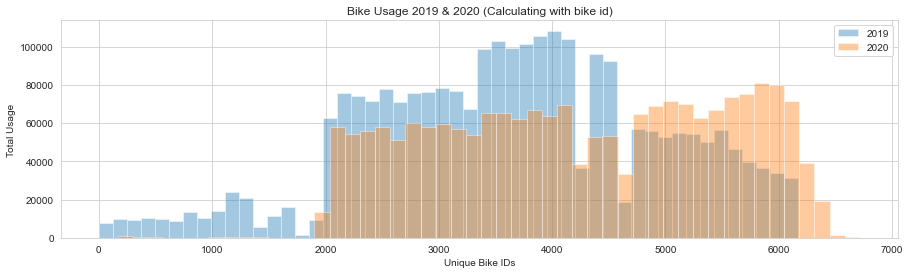

In [15]:
plt.figure(figsize=(15,4))
sns.distplot(trip_2019["bikeid"], kde=False, bins=50, label="2019")
sns.distplot(trip_2020["bikeid"], kde=False, bins=50, label="2020")
plt.title("Bike Usage 2019 & 2020 (Calculating with bike id)")
plt.xlabel("Unique Bike IDs")
plt.ylabel("Total Usage")
plt.legend()

## It seems some bikes which were used in 2019 did not used in 2020 (left side)
## Probably bikes are getting renewed

#### Let's take a look at bike-using times in a day

In [16]:
to_datetime_2019 = pd.to_datetime(trip_2019["starttime"])
to_datetime_2020 = pd.to_datetime(trip_2020["starttime"])

In [17]:
### Checking the using hours in 2019

hours_2019 = []
for i in to_datetime_2019:
    hours_2019.append(i.hour)

night_hours_2019 = 0
am_hours_2019 = 0
pm_hours_2019 = 0
for x in hours_2019:
    if x in [0,1,2,3,4,5]:
        night_hours_2019 += 1
    elif x in [6,7,8,9,10,11]:
        am_hours_2019 += 1
    else:
        pm_hours_2019 += 1

print("At Night Hours:",night_hours_2019)
print("Before Midday:",am_hours_2019)
print("After Midday:",pm_hours_2019)

At Night Hours: 64997
Before Midday: 768299
After Midday: 1689475


In [18]:
### Checking the using hours in 2020

hours_2020 = []
for i in to_datetime_2020:
    hours_2020.append(i.hour)

night_hours_2020 = 0
am_hours_2020 = 0
pm_hours_2020 = 0
for x in hours_2020:
    if x in [0,1,2,3,4,5]:
        night_hours_2020 += 1
    elif x in [6,7,8,9,10,11]:
        am_hours_2020 += 1
    else:
        pm_hours_2020 += 1

print("At Night Hours:",night_hours_2020)
print("Before Midday:",am_hours_2020)
print("After Midday:",pm_hours_2020)

At Night Hours: 62231
Before Midday: 483118
After Midday: 1454097


In [19]:
busy_times_2019 = pd.DataFrame([night_hours_2019,am_hours_2019,pm_hours_2019]).transpose()
busy_times_2019.columns = ["At Night Hours", "Before Midday", "After Midday"]
busy_times_2019.index = [2019]

busy_times_2020 = pd.DataFrame([night_hours_2020,am_hours_2020,pm_hours_2020]).transpose()
busy_times_2020.columns = ["At Night Hours", "Before Midday", "After Midday"]
busy_times_2020.index = [2020]

combine_19_20 = pd.concat([busy_times_2019,busy_times_2020])
combine_19_20

,At Night Hours,Before Midday,After Midday
2019,64997,768299,1689475
2020,62231,483118,1454097


' It seems the customers highly prefer using bike after midday '

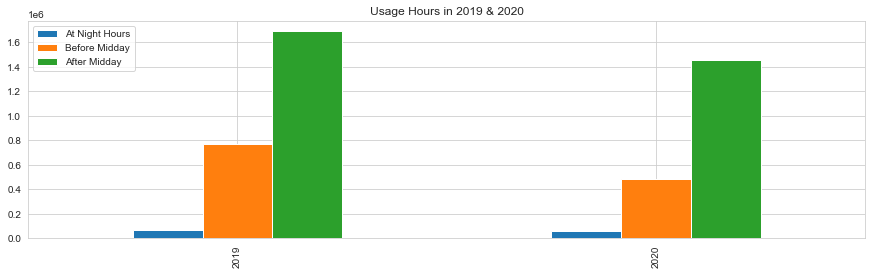

In [20]:
combine_19_20.plot(kind="bar", figsize=(15,4))
plt.title("Usage Hours in 2019 & 2020")
## It seems the customers highly prefer using bike after midday '''

#### Now, we are going to try clustering this data

In [21]:
new_data = trip_2019[["tripduration","usertype","month"]]
new_data[["Customer","Subscriber"]] = pd.get_dummies(new_data["usertype"])

new_data["month"] = new_data["month"].map({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July",
                      8:"August", 9:"September", 10:"October", 11:"November", 12:"December"})

new_data[['April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September']] = pd.get_dummies(new_data["month"])

new_data.drop(new_data[["usertype","month"]],axis=1,inplace=True)

C:\Users\ayhan\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-21-13a516962d87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["month"] = new_data["month"].map({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July",


In [22]:
new_data.head()

,tripduration,Customer,Subscriber,April,August,December,February,January,July,June,March,May,November,October,September
0,790,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,166,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,323,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,709,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,332,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [23]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(new_data.loc[:250000])
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

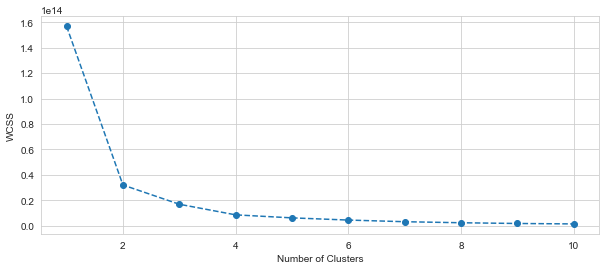

In [24]:
plt.figure(figsize=(10,4))
plt.plot(range(1,11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

In [25]:
''' It seems we have 3 clusters '''
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans.fit(new_data)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

#### Let's try to plot them (just for fun)

In [26]:
new_data["Segment K-means"] = kmeans.labels_
df_segm_analysis = new_data.groupby(["Segment K-means"]).mean()
df_segm_analysis["Prop Obs"] = new_data.groupby(["Segment K-means"]).count()["tripduration"] / len(new_data)

In [27]:
df_segm_analysis

,tripduration,Customer,Subscriber,April,August,December,February,January,July,June,March,May,November,October,September,Prop Obs
Segment K-means,,,,,,,,,,,,,,,,
0,1.560352e+03,0.211745,0.788255,0.066079,0.133775,0.036552,0.031898,0.027698,0.125656,0.108634,0.04058,0.088433,0.075619,0.121105,0.14397,0.999946
1,7.391625e+06,0.898148,0.101852,0.000000,0.370370,0.000000,0.000000,0.000000,0.314815,0.314815,0.00000,0.000000,0.000000,0.000000,0.00000,0.000043
2,2.718311e+07,0.857143,0.142857,0.000000,0.500000,0.000000,0.000000,0.000000,0.357143,0.142857,0.00000,0.000000,0.000000,0.000000,0.00000,0.000011


In [28]:
new_trip_2019 = trip_2019.copy()

new_trip_2019["Labels"] = new_data["Segment K-means"].map(({0:"Regular Subscriber (Short Distance)",
                        1:"Summer Customer (Long Distance)",
                        2:"Summer Customer (Short Distance)"}))

In [29]:
new_trip_2019.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,year,month,Labels
0,790,2019-12-01 00:01:25.3240,2019-12-01 00:14:35.3350,370,Dartmouth St at Newbury St,42.350961,-71.077828,33,Kenmore Square,42.348706,-71.097009,5133,Subscriber,2019,12,Regular Subscriber (Short Distance)


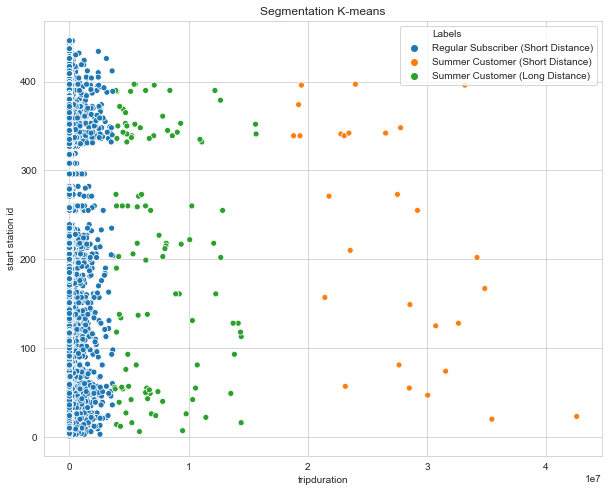

In [30]:
x_axis = new_trip_2019["tripduration"]
y_axis = new_trip_2019["start station id"]

plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=new_trip_2019["Labels"])
plt.title("Segmentation K-means")
plt.show()